<a href="https://colab.research.google.com/github/Shameema-hooriyah/CIFAR100-Image-Classification/blob/main/8_CIFAR_100_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Setup:

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [29]:
import keras

(cifar100_train_images, cifar100_train_labels), (cifar100_test_images, cifar100_test_labels) = keras.datasets.cifar100.load_data()

print("CIFAR-100 Training images shape:", cifar100_train_images.shape)
print("CIFAR-100 Testing images shape:", cifar100_test_images.shape)
print("CIFAR-100 Training labels shape:", cifar100_train_labels.shape)
print("CIFAR-100 Testing labels shape:", cifar100_test_labels.shape)

CIFAR-100 Training images shape: (50000, 32, 32, 3)
CIFAR-100 Testing images shape: (10000, 32, 32, 3)
CIFAR-100 Training labels shape: (50000, 1)
CIFAR-100 Testing labels shape: (10000, 1)


Normalize Data


In [30]:
cifar100_train_images = cifar100_train_images / 255.0
cifar100_test_images = cifar100_test_images / 255.0

Reshape Data

In [31]:
import tensorflow as tf
import numpy as np

# --- Explanation of the original error: ---
# The original code tried to reshape cifar100_train_images from (50000, 32, 32, 3)
# into (50000, 32, 32, 1). A reshape operation can only rearrange existing elements,
# not change the total count. (50000 * 32 * 32 * 3 = 153,600,000) is not equal to
# (50000 * 32 * 32 * 1 = 51,200,000), hence the ValueError.
# To change the number of color channels, an image processing function is needed.

# --- Corrected data preparation for CIFAR-100 to match model expectations: ---
# Your models (ann_model, deeper_cnn_model) are defined with `input_shape=(28, 28, 1)`
# and `Dense(10, activation='softmax')` for 10 output classes. CIFAR-100 images are
# 32x32 with 3 color channels and 100 classes. We will process the CIFAR-100 data
# to match your model's expectations.

# 1. Convert CIFAR-100 images to grayscale (1 channel)
cifar100_train_images_gray = tf.image.rgb_to_grayscale(cifar100_train_images)
cifar100_test_images_gray = tf.image.rgb_to_grayscale(cifar100_test_images)

# 2. Resize images from 32x32 to 28x28
train_images_resized = tf.image.resize(cifar100_train_images_gray, (28, 28)).numpy()
test_images_resized = tf.image.resize(cifar100_test_images_gray, (28, 28)).numpy()

# 3. Handle labels: CIFAR-100 has 100 classes, but your model expects 10.
# We will filter the CIFAR-100 data to include only the first 10 classes (0-9).
# If you intend to train on all 100 classes, you must adjust your model's output layer.

# Find indices for the first 10 classes
train_indices_10_classes = np.where(cifar100_train_labels < 10)[0]
test_indices_10_classes = np.where(cifar100_test_labels < 10)[0]

# Filter images and labels, and assign to the variables expected by later cells
train_images = train_images_resized[train_indices_10_classes]
train_labels = cifar100_train_labels[train_indices_10_classes] # Keep original labels for one-hot encoding

test_images = test_images_resized[test_indices_10_classes]
test_labels = cifar100_test_labels[test_indices_10_classes] # Keep original labels for one-hot encoding

# Ensure labels are one-hot encoded for 10 classes.
# keras.utils.to_categorical is imported in an earlier cell (3EB8qWlpT97a).
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_one_hot = keras.utils.to_categorical(test_labels, num_classes=10)

print("Final Training images shape:", train_images.shape)
print("Final Testing images shape:", test_images.shape)
print("Final Training labels shape:", train_labels_one_hot.shape)
print("Final Testing labels shape:", test_labels_one_hot.shape)

Final Training images shape: (5000, 28, 28, 1)
Final Testing images shape: (1000, 28, 28, 1)
Final Training labels shape: (5000, 10)
Final Testing labels shape: (1000, 10)


 One-Hot Encode Labels

In [32]:
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_one_hot = keras.utils.to_categorical(test_labels, num_classes=10)

In [33]:
print("Training images shape:", train_images.shape)
print("Testing images shape:", test_images.shape)
print("Training labels shape:", train_labels_one_hot.shape)
print("Testing labels shape:", test_labels_one_hot.shape)

Training images shape: (5000, 28, 28, 1)
Testing images shape: (1000, 28, 28, 1)
Training labels shape: (5000, 10)
Testing labels shape: (1000, 10)


2. Model Building

Basic ANN Model

In [34]:
ann_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)), # Corrected input shape to match processed images
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

ann_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

ann_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
basic_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), # Corrected input shape
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax') # Corrected to 10 output classes
])


basic_cnn_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

basic_cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Deeper CNN Model

In [36]:
deeper_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), # Corrected input shape
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax') # Corrected to 10 output classes
])

deeper_cnn_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

deeper_cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,882 (437.04 KB)

 Trainable params: 111,178 (434.29 KB)

 Non-trainable params: 704 (2.75 KB)

Training ANN Model

In [37]:
from tensorflow import keras # Added import statement

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint_ann = keras.callbacks.ModelCheckpoint(
    filepath='best_ann_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training ANN model...")
ann_history = ann_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=60,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_ann]
)
print("ANN model training finished.")

Training ANN model...
Epoch 1/30
79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1689 - loss: 2.2687
Epoch 1: val_loss improved from inf to 2.07229, saving model to best_ann_model_weights.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1720 - loss: 2.2623 - val_accuracy: 0.2790 - val_loss: 2.0723
Epoch 2/30
79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2697 - loss: 2.0638
Epoch 2: val_loss improved from 2.07229 to 1.92290, saving model to best_ann_model_weights.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2707 - loss: 2.0602 - val_accuracy: 0.3260 - val_loss: 1.9229
Epoch 3/30
75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3182 - loss: 1.9250
Epoch 3: val_loss improved from 1.92290 to 1.86577, saving model to best_ann_model_weights.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3192 - loss: 1.9239 - val_accuracy: 0.3210 - val_loss: 1.8658
Epoch 4/30
76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3425 - loss: 1

Training Basic CNN Model

In [38]:
model_checkpoint_basic_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_basic_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training Basic CNN model...")
basic_cnn_history = basic_cnn_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_basic_cnn]
)
print("Basic CNN model training finished.")

Training Basic CNN model...
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1785 - loss: 2.2480
Epoch 1: val_loss improved from inf to 1.84152, saving model to best_basic_cnn_model_weights.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1792 - loss: 2.2468 - val_accuracy: 0.3660 - val_loss: 1.8415
Epoch 2/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3492 - loss: 1.8556
Epoch 2: val_loss improved from 1.84152 to 1.71541, saving model to best_basic_cnn_model_weights.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3497 - loss: 1.8550 - val_accuracy: 0.4030 - val_loss: 1.7154
Epoch 3/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4300 - loss: 1.7108
Epoch 3: val_loss improved from 1.71541 to 1.61035, saving model to best_basic_cnn_model_weights.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.4303 - loss: 1.7103 - val_accuracy: 0.4480 - val_loss: 1.6103
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste

Training Deeper CNN Model

In [39]:
model_checkpoint_deeper_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_deeper_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training Deeper CNN model...")
deeper_cnn_history = deeper_cnn_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_deeper_cnn]
)
print("Deeper CNN model training finished.")

Training Deeper CNN model...
Epoch 1/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1594 - loss: 3.0869
Epoch 1: val_loss improved from inf to 2.36265, saving model to best_deeper_cnn_model_weights.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.1602 - loss: 3.0802 - val_accuracy: 0.1000 - val_loss: 2.3626
Epoch 2/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2397 - loss: 2.4378
Epoch 2: val_loss did not improve from 2.36265
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.2400 - loss: 2.4357 - val_accuracy: 0.1400 - val_loss: 2.3850
Epoch 3/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3029 - loss: 2.1238
Epoch 3: val_loss did not improve from 2.36265
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.3033 - loss: 2.1222 - val_accuracy: 0.1200 - val_loss: 2.3958
Epoch 4/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3462 - loss: 1.9525
Epoch 4: val_loss improved from 2.36265 to 2.34533, saving model to best_deepe

Model Evaluation

In [40]:
ann_model.evaluate(test_images, test_labels_one_hot)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3624 - loss: 1.7673


[1.700912594795227, 0.40299999713897705]

/tmp/ipython-input-2215778233.py:42: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


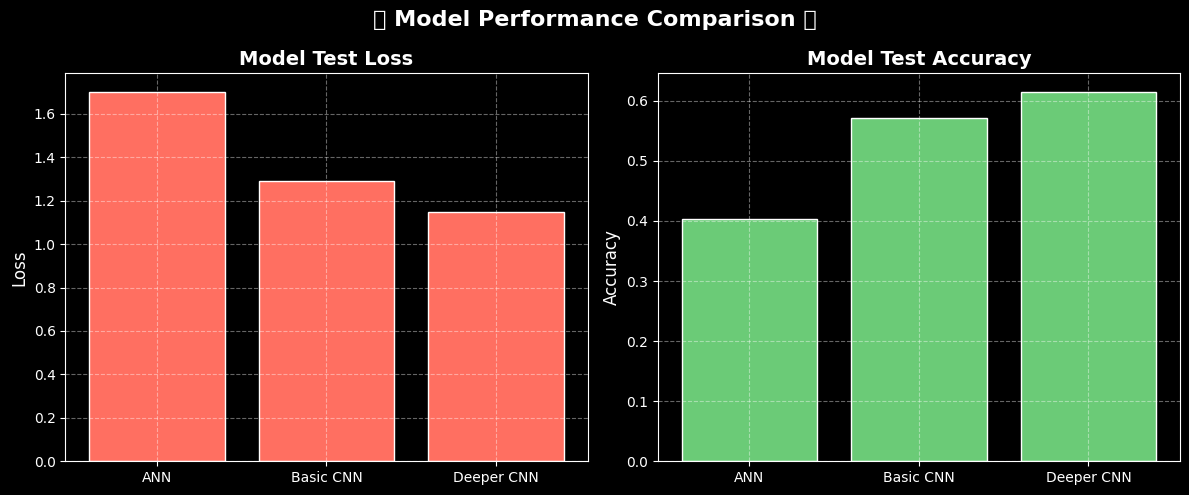

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

ann_model.load_weights('best_ann_model_weights.weights.h5')
basic_cnn_model.load_weights('best_basic_cnn_model_weights.weights.h5')
deeper_cnn_model.load_weights('best_deeper_cnn_model_weights.weights.h5')

loss_ann, accuracy_ann = ann_model.evaluate(test_images, test_labels_one_hot, verbose=0)
loss_basic_cnn, accuracy_basic_cnn = basic_cnn_model.evaluate(test_images, test_labels_one_hot, verbose=0)
loss_deeper_cnn, accuracy_deeper_cnn = deeper_cnn_model.evaluate(test_images, test_labels_one_hot, verbose=0)


import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['ANN', 'Basic CNN', 'Deeper CNN']
losses = [loss_ann, loss_basic_cnn, loss_deeper_cnn]
accuracies = [accuracy_ann, accuracy_basic_cnn, accuracy_deeper_cnn]

# Dark mode style
plt.style.use("dark_background")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].bar(models, losses, color='#FF6F61', edgecolor='white')
axes[0].set_title('Model Test Loss', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.4)

# Accuracy plot
axes[1].bar(models, accuracies, color='#6BCB77', edgecolor='white')
axes[1].set_title('Model Test Accuracy', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.4)

# Overall title
plt.suptitle("✨ Model Performance Comparison ✨", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


Model Evaluation (Confusion Matrix & Report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


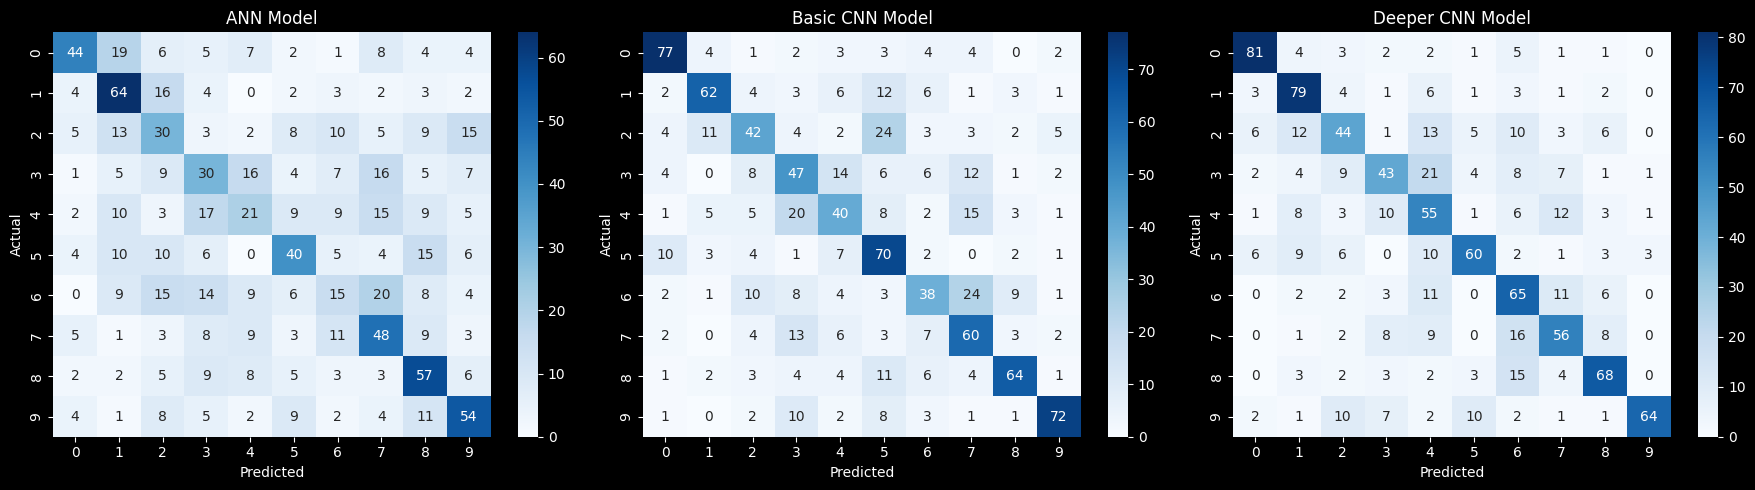

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions
ann_predictions = ann_model.predict(test_images)
basic_cnn_predictions = basic_cnn_model.predict(test_images)
deeper_cnn_predictions = deeper_cnn_model.predict(test_images)

# Convert labels
test_labels_int = np.argmax(test_labels_one_hot, axis=1)

ann_predicted_labels = np.argmax(ann_predictions, axis=1)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)
deeper_cnn_predicted_labels = np.argmax(deeper_cnn_predictions, axis=1)

# Confusion matrices
cm_ann = confusion_matrix(test_labels_int, ann_predicted_labels)
cm_basic = confusion_matrix(test_labels_int, basic_cnn_predicted_labels)
cm_deeper = confusion_matrix(test_labels_int, deeper_cnn_predicted_labels)

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("ANN Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_basic, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Basic CNN Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_deeper, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("Deeper CNN Model")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Model Comparison

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

models = {
    "ANN": ("cyan", ann_history),
    "Basic CNN": ("magenta", basic_cnn_history),
    "Deeper CNN": ("yellow", deeper_cnn_history)
}

performance_data = {
    'Model': ['ANN', 'Basic CNN', 'Deeper CNN'],
    'Test Loss': [loss_ann, loss_basic_cnn, loss_deeper_cnn],
    'Test Accuracy': [accuracy_ann, accuracy_basic_cnn, accuracy_deeper_cnn]
}

performance_df = pd.DataFrame(performance_data)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

for name, (color, history) in models.items():
    # Accuracy
    fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines',
                             name=name, line=dict(color=color, dash='solid')), row=1, col=1)
    fig.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines',
                             name=name, line=dict(color=color, dash='dot'), showlegend=False), row=1, col=1)

    # Loss
    fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines',
                             name=name, line=dict(color=color, dash='solid')), row=1, col=2)
    fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines',
                             name=name, line=dict(color=color, dash='dot'), showlegend=False), row=1, col=2)

fig.update_layout(
    title_text="Model Comparison: Accuracy & Loss (Train=Solid, Val=Dot)",
    height=500,
    width=1200,
    template="plotly_dark"
)

fig.show()

Predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


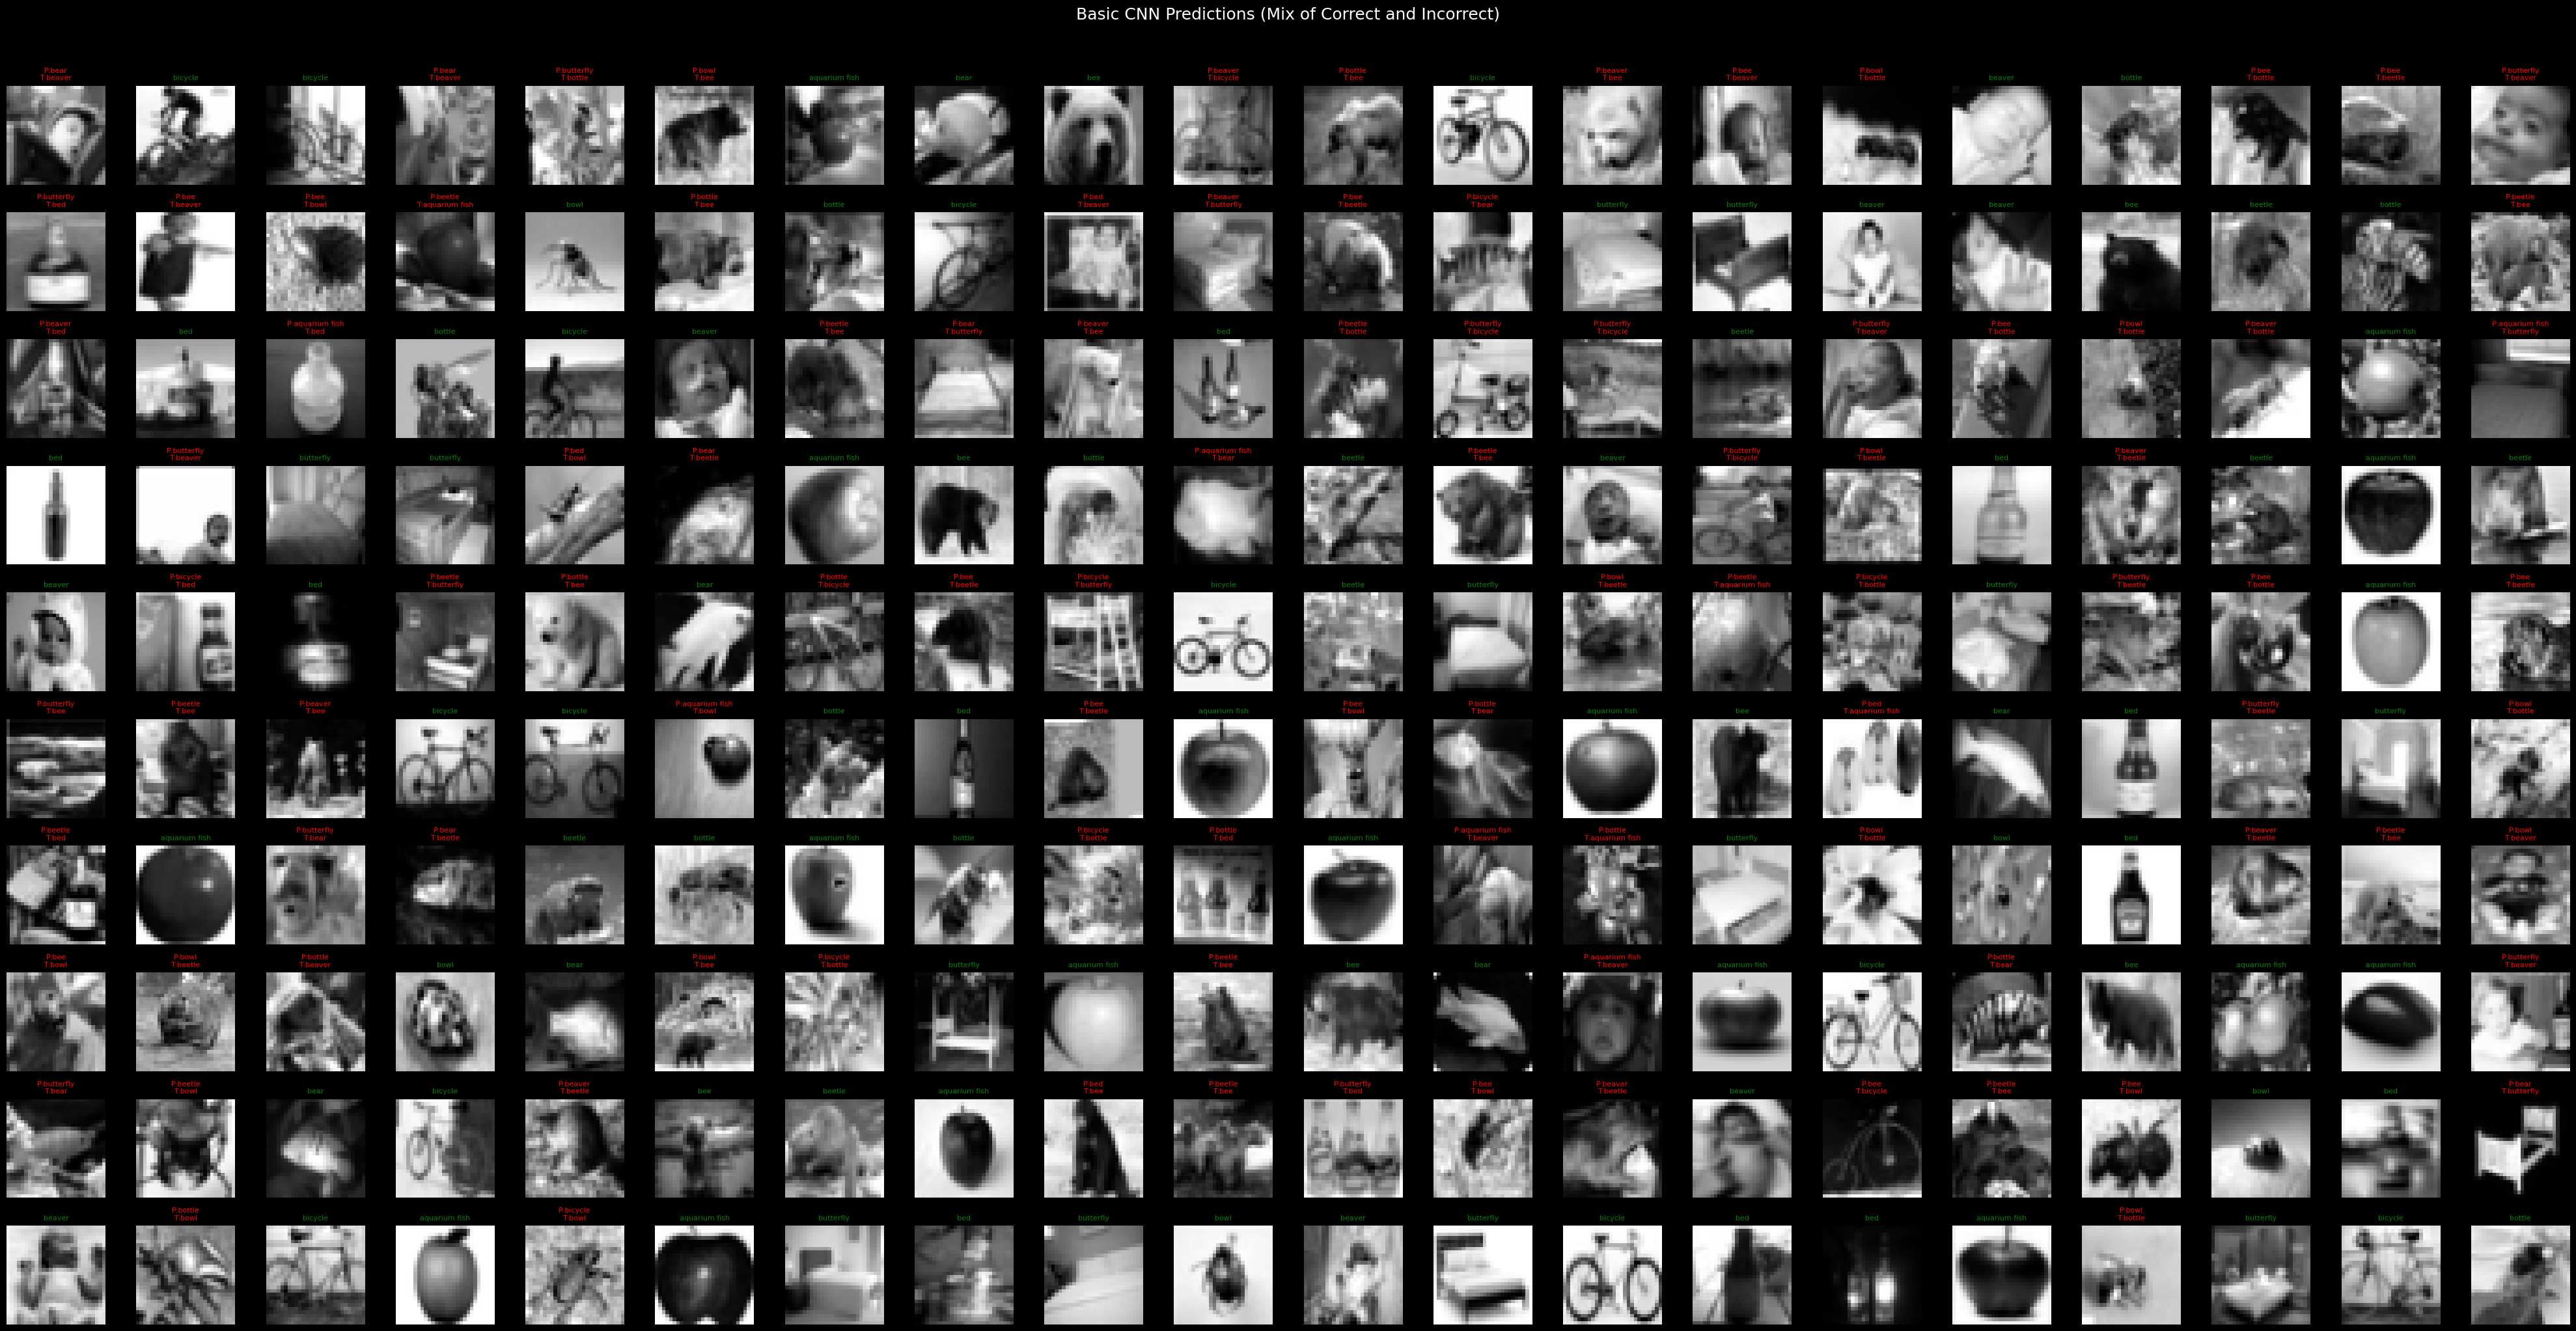

In [46]:
basic_cnn_predictions = basic_cnn_model.predict(test_images)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)

# Find correctly and incorrectly classified images
correctly_classified_indices = np.where(basic_cnn_predicted_labels == test_labels.flatten())[0]
incorrectly_classified_indices = np.where(basic_cnn_predicted_labels != test_labels.flatten())[0]

# Define class names for CIFAR100
class_names = ['aquarium fish', 'bear', 'beaver', 'bee', 'beetle', 'butterfly',
               'bottle', 'bowl', 'bicycle', 'bed', 'bridge', 'bus', 'apple',
               'maple tree', 'oak tree', 'pine tree', 'willow tree', 'orchid', 'poppy', 'rose', 'sunflower', 'tulip'
]

# Select a mix of correctly and incorrectly classified images
num_correct_to_show = 100
num_incorrect_to_show = 100

# Ensure we don't try to show more images than available
num_correct_to_show = min(num_correct_to_show, len(correctly_classified_indices))
num_incorrect_to_show = min(num_incorrect_to_show, len(incorrectly_classified_indices))

selected_correct_indices = np.random.choice(correctly_classified_indices, num_correct_to_show, replace=False)
selected_incorrect_indices = np.random.choice(incorrectly_classified_indices, num_incorrect_to_show, replace=False)

# Combine and shuffle the indices
all_indices = np.concatenate((selected_correct_indices, selected_incorrect_indices))
np.random.shuffle(all_indices)

# Display images in a 20x10 grid
num_cols = 20
num_rows = 10
num_images_to_show = num_correct_to_show + num_incorrect_to_show

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
fig.suptitle("Basic CNN Predictions (Mix of Correct and Incorrect)", fontsize=18, y=1.02)

for i, idx in enumerate(all_indices[:num_images_to_show]):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(test_images[idx].reshape(28, 28), cmap='gray')

    pred = class_names[basic_cnn_predicted_labels[idx]]
    true = class_names[test_labels[idx].item()] # Corrected: use .item() to get scalar

    if basic_cnn_predicted_labels[idx] == test_labels[idx].item(): # Corrected: use .item() for comparison
        color = "green"
        title = f"{pred}"
    else:
        color = "red"
        title = f"P:{pred}\nT:{true}"

    axes[row, col].set_title(title, fontsize=8, color=color)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()